In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

# Train/Test Split

In [36]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop(columns=['location'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [38]:
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,continent_Asia,continent_Europe,continent_North America,continent_South America,tests_units_people tested,tests_units_tests performed,season_Autumn,season_Spring,season_Summer,season_Winter
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-08,316.0,315.0,0.0,27.111,27.025,0.000,0.000,NaN,NaN,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-15,1362.0,1046.0,9.0,116.850,89.740,4.547,22.564,NaN,18.960,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-22,4473.0,3111.0,140.0,383.753,266.903,27.969,142.503,NaN,128.604,NaN,...,0,1,0,0,0,1,0,1,0,0
2020-03-29,12031.0,7558.0,602.0,1032.179,648.426,82.447,389.158,NaN,300.191,NaN,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-10,103436829.0,NaN,1614.0,305763.910,NaN,7.168,58.512,NaN,70.395,NaN,...,0,0,1,0,0,0,0,0,0,1
2023-12-17,103436829.0,NaN,1450.0,305763.910,NaN,7.325,62.390,NaN,75.678,NaN,...,0,0,1,0,0,0,0,0,0,1
2023-12-24,103436829.0,NaN,1263.0,305763.910,NaN,8.546,68.988,NaN,89.101,NaN,...,0,0,1,0,0,0,0,0,0,1


In [39]:
train_size = int(len(df) * 0.7)
train, test = df[0:train_size], df[train_size:]
print(train.shape, test.shape)

(1416, 57) (607, 57)


# XGBoost Model with Early Stopping

In [40]:
X_train = train.drop(columns=['new_deaths']) 
X_test = test.drop(columns=['new_deaths']) 
y_train = train['new_deaths']
y_test = test['new_deaths']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1416, 56) (1416,) (607, 56) (607,)


In [61]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=10000, early_stopping_rounds=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[22:30:06] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:496.49078	validation_1-rmse:4496.82422
[1]	validation_0-rmse:379.89758	validation_1-rmse:4427.04053
[2]	validation_0-rmse:295.89816	validation_1-rmse:4093.03320


[3]	validation_0-rmse:233.39131	validation_1-rmse:3934.13037
[4]	validation_0-rmse:186.75737	validation_1-rmse:3802.28467
[5]	validation_0-rmse:150.89937	validation_1-rmse:3782.19897
[6]	validation_0-rmse:123.33690	validation_1-rmse:3568.56079
[7]	validation_0-rmse:101.62997	validation_1-rmse:3395.05444
[8]	validation_0-rmse:84.46410	validation_1-rmse:3247.97363
[9]	validation_0-rmse:70.46437	validation_1-rmse:3125.52148
[10]	validation_0-rmse:58.99172	validation_1-rmse:3025.39551
[11]	validation_0-rmse:49.63191	validation_1-rmse:2939.69873
[12]	validation_0-rmse:41.84086	validation_1-rmse:2869.48462
[13]	validation_0-rmse:35.41700	validation_1-rmse:2809.10596
[14]	validation_0-rmse:30.03122	validation_1-rmse:2759.66504
[15]	validation_0-rmse:25.54238	validation_1-rmse:2717.64673
[16]	validation_0-rmse:21.75324	validation_1-rmse:2682.13159
[17]	validation_0-rmse:18.59397	validation_1-rmse:2652.13940
[18]	validation_0-rmse:15.93362	validation_1-rmse:2626.86401
[19]	validation_0-rmse:13.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=100,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

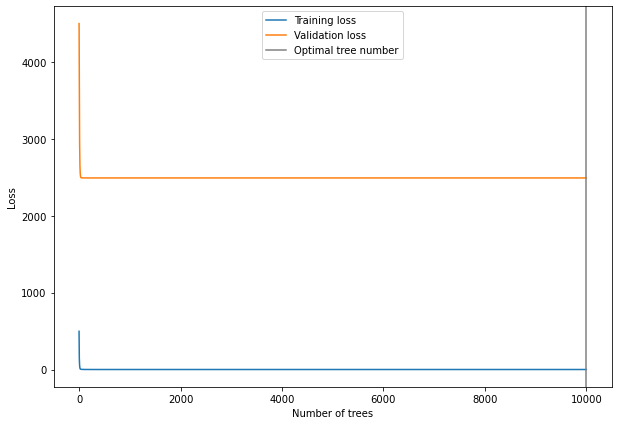

In [62]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [63]:
reg.best_iteration

9999

# Feature Importance

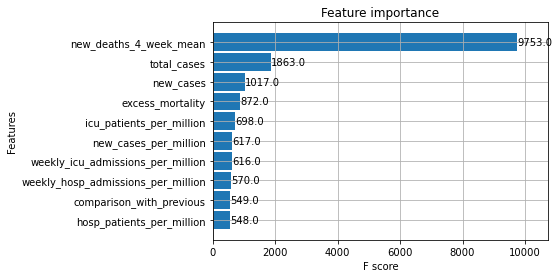

In [64]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

# Forcast on Test Set

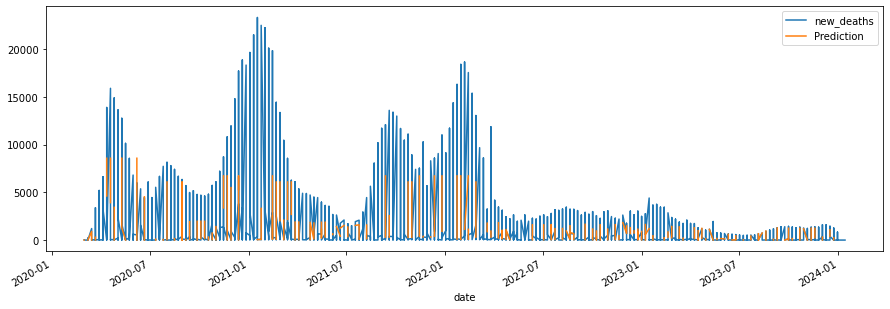

In [65]:
test['Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([test, train], sort=False)
_ = pjme_all[['new_deaths','Prediction']].plot(figsize=(15, 5))

# Metrics

In [66]:
model_rmse = mean_squared_error(test['new_deaths'], test['Prediction'], squared=False)
model_mae = mean_absolute_error(test['new_deaths'], test['Prediction'])
print('Test RMSE: ', model_rmse)
print('Test MAE: ', model_mae)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
model_mape = mean_absolute_percentage_error(y_true=test['new_deaths'], y_pred=test['Prediction'])
print('Test MAPE: ', model_mape)

Test RMSE:  2490.1687746952666
Test MAE:  926.076735371506
Test MAPE:  inf
